<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 20%;">
   

# Fabwave - Part Classification using HOOPS AI

In this notebook, we preprocess a list of cadfiles for part classification.

in here:

- Gather a labeled dataset (fabave) located in the packages folder 
- Preprocess the cad files to be ML-input ready
- Preprocess the labels to be injected in the pipeline
- Create a dataset and dgl directories with the data ready for Training
- Train the ML model using the GraphClassification model

This is an example that only uses 4500 cadfiles. With 45 different part categories. 

In [2]:
import hoops_ai
import os

hoops_ai.set_license(hoops_ai.use_test_license(), validate=False)



HOOPS AI version :  1.0.0-b2dev3 



C:\Users\LuisSalazar\AppData\Local\Temp\ipykernel_36448\512963169.py:4: UserWarning: ⚠️ TEST LICENSE expires in 5 days (January 31, 2026)!
   Please obtain your own license from Tech Soft 3D.
   Visit: https://www.techsoft3d.com/contact/
  hoops_ai.set_license(hoops_ai.use_test_license(), validate=False)


In [3]:
# Using a test flow name for 10-file test
from scripts.cad_tasks_fabwave import get_flow_name
flow_name = get_flow_name()
print(f"Flow name: {flow_name}")

2026-01-25 17:22:25 | INFO | numexpr.utils | NumExpr defaulting to 16 threads.


HOOPS AI version :  1.0.0-b2dev3 

Flow name: ETL_Fabwave_training_b2


In [4]:
import os
import pathlib
from typing import Tuple, List

# Import the flow builder framework from the library
import hoops_ai
from hoops_ai.flowmanager import flowtask


from hoops_ai.cadaccess import HOOPSLoader, HOOPSTools
from hoops_ai.cadencoder import BrepEncoder
from hoops_ai.dataset import DatasetExplorer
from hoops_ai.storage import DataStorage, CADFileRetriever, LocalStorageProvider
from hoops_ai.storage.datasetstorage.schema_builder import SchemaBuilder

## Configuring Setup

In [5]:
# Configuration - Using simpler paths
nb_dir = pathlib.Path.cwd()
flows_outputdir = nb_dir.joinpath("out")
# Import task functions from external module for ProcessPoolExecutor compatibility
from scripts.cad_tasks_fabwave import gather_fabwave_files, encode_data_for_ml_training, my_workflow_for_fabewave, get_flow_name

## ETL Data pipeline


In [6]:
# data source
datasources_dir = [str(nb_dir.parent.joinpath("packages","cadfiles","fabwave"))
    #str(nb_dir.parent.joinpath("packages","cadfiles","fabwave", "CAD_1_15_Classes", "Bolts")),
    #str(nb_dir.parent.joinpath("packages","cadfiles","fabwave", "CAD_1_15_Classes", "Bushing_Damping_Liners")),
    #str(nb_dir.parent.joinpath("packages","cadfiles","fabwave", "CAD25-45_TOTAL1000", "Sleeve Washers"))   
                  ]

In [7]:
from display_utils import display_task_source
display_task_source(gather_fabwave_files, "gather_fabwave_files")

---

### `gather_fabwave_files`

```python
@flowtask.extract(
    name="gather fabwave files",
    inputs=["cad_datasources"],
    outputs=["cad_dataset"],
    parallel_execution=True
)
def gather_fabwave_files(source: str) -> List[str]:

    # Example 1: Basic retrieval with format filtering
    retriever = CADFileRetriever(
        storage_provider=LocalStorageProvider(directory_path=source),
        formats=[".stp", ".step", ".iges", ".igs"],
        #filter_pattern="*5*"  # Only files with "5" in name
    )
            
    # Get files using the library's retriever
    source_files = retriever.get_file_list()
    
    # Shuffle to get random sample instead of first N files in order
    import random
    random.seed(42)  # For reproducibility
    shuffled_files = source_files.copy()
    random.shuffle(shuffled_files)
    
    return shuffled_files #[:100]
```


In [8]:
labels_description = {
        0: {"name": "Bearings"              , "description": " fabewave dataset sample  "},
        1: {"name": "Bolts"                 , "description": " fabewave dataset sample  "},
        2: {"name": "Brackets"              , "description": " fabewave dataset sample  "},
        3: {"name": "Bushing"               , "description": " fabewave dataset sample  "},
        4: {"name": "Bushing_Damping_Liners", "description": " fabewave dataset sample  "},
        5: {"name": "Collets"               , "description": " fabewave dataset sample  "},
        6: {"name": "Gasket"                , "description": " fabewave dataset sample  "},
        7: {"name": "Grommets"              , "description": " fabewave dataset sample  "},
        8: {"name": "HeadlessScrews"        , "description": " fabewave dataset sample  "},
        9: {"name": "Hex_Head_Screws"       , "description": " fabewave dataset sample  "},
        10: {"name": "Keyway_Shaft"         , "description": " fabewave dataset sample  "},
        11: {"name": "Machine_Key"          , "description": " fabewave dataset sample  "},
        12: {"name": "Nuts"                 , "description": " fabewave dataset sample  "},
        13: {"name": "O_Rings"              , "description": " fabewave dataset sample  "},
        14: {"name": "Thumb_Screws"        , "description": " fabewave dataset sample   "},
        15: {"name": "Pipe_Fittings"        , "description": " fabewave dataset sample   "},
        16: {"name": "Pipe_Joints"              , "description": " fabewave dataset sample  "},
        17: {"name": "Pipes"                 , "description": " fabewave dataset sample  "},
        18: {"name": "Rollers"              , "description": " fabewave dataset sample  "},
        19: {"name": "Rotary_Shaft"               , "description": " fabewave dataset sample  "},
        20: {"name": "Shaft_Collar"         , "description": " fabewave dataset sample  "},
        21: {"name": "Slotted_Flat_Head_Screws"               , "description": " fabewave dataset sample  "},
        22: {"name": "Socket_Head_Screws"               , "description": " fabewave dataset sample  "},
        23: {"name": "Washers"                , "description": " fabewave dataset sample  "},
        24: {"name": "Boxes"              , "description": " fabewave dataset sample  "},
        25: {"name": "Cotter_Pin"        , "description": " fabewave dataset sample  "},
        26: {"name": "External Retaining Rings"       , "description": " fabewave dataset sample  "},
        27: {"name": "Eyesbolts With Shoulders"         , "description": " fabewave dataset sample  "},
        28: {"name": "Fixed Cap Flange"          , "description": " fabewave dataset sample  "},
        29: {"name": "Gear Rod Stock"                 , "description": " fabewave dataset sample  "},
        30: {"name": "Gears"              , "description": " fabewave dataset sample  "},
        31: {"name": "Holebolts With Shoulders"        , "description": " fabewave dataset sample   "},
        32: {"name": "Idler Sprocket"        , "description": " fabewave dataset sample   "},
        33: {"name": "Miter Gear Set Screw"        , "description": " fabewave dataset sample   "},
        34: {"name": "Miter Gears"        , "description": " fabewave dataset sample   "},
        35: {"name": "Rectangular Gear Rack"        , "description": " fabewave dataset sample   "},
        36: {"name": "Routing EyeBolts Bent Closed Eye"        , "description": " fabewave dataset sample   "},
        37: {"name": "Sleeve Washers"        , "description": " fabewave dataset sample   "},
        38: {"name": "Socket-Connect Flanges"        , "description": " fabewave dataset sample   "},
        39: {"name": "Sprocket Taper-Lock Bushing"        , "description": " fabewave dataset sample   "},
        40: {"name": "Strut Channel Floor Mount"        , "description": " fabewave dataset sample   "},
        41: {"name": "Strut Channel Side-Side"        , "description": " fabewave dataset sample   "},
        42: {"name": "Tag Holder"        , "description": " fabewave dataset sample   "},
        43: {"name": "Webbing Guide"        , "description": " fabewave dataset sample   "},
        44: {"name": "Wide Grip External Retaining Ring"        , "description": " fabewave dataset sample   "},
    }

# Invert the dictionary
description_to_code = {v["name"]: k for k, v in labels_description.items()}

# Data Transformation : Encoded data to be used as ml input

In [9]:
display_task_source(encode_data_for_ml_training, "encode_data_for_ml_training")

---

### `encode_data_for_ml_training`

```python
@flowtask.transform(
    name="Preparing data for Exploring and ML training",
    inputs=["cad_dataset"],
    outputs=["cad_files_encoded"],
    parallel_execution=True
)
def encode_data_for_ml_training(cad_file: str, cad_loader :  HOOPSLoader, storage : DataStorage) -> str:
    import numpy as np
    import random

    cad_model = cad_loader.create_from_file(cad_file)
    storage.set_schema(cad_schema)

    facecount, edgecount = my_workflow_for_fabewave.encode_cad_data(cad_file, cad_loader, storage)
    
    # Add label data
    folder_with_name = str(pathlib.Path(cad_file).parent.parent.stem)
    label_code = description_to_code.get(folder_with_name, None)
    
    # Validate label_code - skip if unknown category
    if label_code is None:
        raise ValueError(f"Unknown category '{folder_with_name}' for file {cad_file}. Category not found in labels_description.")
    
    label_description = [{int(label_code) : labels_description[label_code]["name"]} ]
    
    # Save label data in the schema-defined group for dataset analytics
    storage.save_data("Labels/part_label", np.array([label_code]))
    storage.save_metadata("part_label_description", folder_with_name)
    
    # ALSO save label using the key expected by GraphClassification.convert_encoded_data_to_graph
    # This is required for the DGL graph files to have the correct labels
    storage.save_data(LabelStorage.GRAPH_CADENTITY, np.array([label_code]))
    
    #my_workflow_for_fabewave.encode_label_data()
    dgl_storage = DGLGraphStoreHandler()

    # DGL graph Bin file
    item_no_suffix = pathlib.Path(cad_file).with_suffix("")  # Remove the suffix to get the base name
    hash_id = generate_unique_id_from_path(str(item_no_suffix))
    dgl_output_path = pathlib.Path(flows_outputdir).joinpath("flows", flow_name, "dgl", f"{hash_id}.ml")  
    dgl_output_path.parent.mkdir(parents=True, exist_ok=True)

    my_workflow_for_fabewave.convert_encoded_data_to_graph(storage, dgl_storage, str(dgl_output_path))
    
    # Save file-level metadata (will be routed to .infoset)
    storage.save_metadata("Item", str(cad_file))
    storage.save_metadata("source", "FABWAVE")
    
    # Compress the storage into a .data file
    storage.compress_store()
    
    # Return the base storage path
    return storage.get_file_path("")
```


## Pipeline execution

In [10]:
# Create and run the Data Flow
flow_name = get_flow_name()
cad_flow = hoops_ai.create_flow(
    name=flow_name,
    tasks=[gather_fabwave_files, encode_data_for_ml_training],
    max_workers=6,
    flows_outputdir=str(flows_outputdir),
    ml_task="Part Classification",
    #debug = True,
    auto_dataset_export=True,  # Enable automatic dataset merging
    export_visualization=True  # Disable visualization export
)

# Run the flow to process all files
print("Starting flow execution with parallel processing...")
flow_output, output_dict, flow_file = cad_flow.process(inputs={'cad_datasources': datasources_dir}, clean_ouput_dir = False)

# Display results
print("\n" + "="*70)
print("FLOW EXECUTION COMPLETED SUCCESSFULLY")
print("="*70)
print(f"\nDataset files created:")
print(f"  Main dataset: {output_dict.get('flow_data', 'N/A')}")
print(f"  Info dataset: {output_dict.get('flow_info', 'N/A')}")
print(f"  Attributes: {output_dict.get('flow_attributes', 'N/A')}")
print(f"  Flow file: {flow_file}")
print(f"\nTotal processing time: {output_dict.get('Duration [seconds]', {}).get('total', 0):.2f} seconds")
print(f"Files processed: {output_dict.get('file_count', 0)}")


Starting flow execution with parallel processing...
|INFO| FLOW | ######### Flow 'ETL_Fabwave_training_b2' start #######
|INFO| FLOW | 
Flow Execution Summary
|INFO| FLOW | ==================================================
|INFO| FLOW | Task 1: gather fabwave files
|INFO| FLOW |     Inputs : cad_datasources
|INFO| FLOW |     Outputs: cad_dataset
|INFO| FLOW | Task 2: Preparing data for Exploring and ML training
|INFO| FLOW |     Inputs : cad_dataset
|INFO| FLOW |     Outputs: cad_files_encoded
|INFO| FLOW | Task 3: AutoDatasetExportTask
|INFO| FLOW |     Inputs : cad_files_encoded
|INFO| FLOW |     Outputs: encoded_dataset, encoded_dataset_info, encoded_dataset_attribs
|INFO| FLOW | 
Task Dependencies:
|INFO| FLOW | gather fabwave files has no dependencies.
|INFO| FLOW | gather fabwave files --> Preparing data for Exploring and ML training
|INFO| FLOW | Preparing data for Exploring and ML training --> AutoDatasetExportTask
|INFO| FLOW | ================================================

DATA INGESTION:   0%|                                                                            | 0/1 [00:00<…

|INFO| FLOW | Executing ParallelTask 'Preparing data for Exploring and ML training' with 4572 items.


DATA TRANSFORMATION:   0%|                                                                    | 0/4572 [00:00<…

|WARNING| FLOW | Total number of items with errors: 31 (0.68%)
|WARNING| FLOW | Corrupted items are listed in 'C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training_b2\error_summary.json'.
|INFO| FLOW | Executing SequentialTask 'AutoDatasetExportTask'.
Sequential Task end=====================
|INFO| FLOW | Time taken: 150.68 seconds
|INFO| FLOW | ######### Flow 'ETL_Fabwave_training_b2' end ######

FLOW EXECUTION COMPLETED SUCCESSFULLY

Dataset files created:
  Main dataset: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training_b2\ETL_Fabwave_training_b2.dataset
  Info dataset: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training_b2\ETL_Fabwave_training_b2.infoset
  Attributes: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training_b2\ETL_Fabwave_training_b2.attribset
  Flow file: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\noteb

## Data Serving : Analytics

In [11]:
# Explore the generated dataset
explorer = DatasetExplorer(flow_output_file=str(flow_file))
explorer.print_table_of_contents()

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:58632' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/4528 [00:00<?, ?it/s]


--- Dataset Table of Contents ---

LABELS_GROUP:
  FILE_ID_CODE_LABELS_DATA: Shape: (4533,), Dims: ('Labels_part_label_dim_0',), Size: 4533
  PART_LABEL_DATA: Shape: (4533,), Dims: ('Labels_part_label_dim_0',), Size: 4533

EDGES_GROUP:
  EDGE_CONVEXITIES_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766
  EDGE_DIHEDRAL_ANGLES_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766
  EDGE_INDICES_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766
  EDGE_LENGTHS_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766
  EDGE_TYPES_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766
  EDGE_U_GRIDS_DATA: Shape: (314766, 10, 6), Dims: ('edge', 'dim_x', 'component'), Size: 18885960
  FILE_ID_CODE_EDGES_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766

FACE_MESH_GROUP:
  FACE_MESH_ADJ_DATA: Shape: (122099, 10000), Dims: ('face', 'component'), Size: 1220990000
  FILE_ID_CODE_FACE_MESH_DATA: Shape: (122099,), Dims: ('face',), Size: 122099

FACES_GROUP:
  FACE_AREAS_DATA: Shape: (12209

## ML-Ready Dataset Preparation

The `DatasetLoader` provides tools for preparing the merged dataset for machine learning:

### Key Capabilities:
- **Stratified Splitting**: Create train/validation/test splits while preserving class distributions
- **Subset Tracking**: Records file assignments in the dataset metadata

In [12]:
print(explorer.available_groups())

{'Labels', 'faces', 'edges', 'graph', 'face_mesh'}


In [13]:
print(explorer.available_arrays('Labels'))

{'file_id_code_Labels', 'part_label'}


In [14]:
# Visualization libraries
import matplotlib.pyplot as plt

def print_distribution_info(dist, title="Distribution"):
    """Helper function to print and visualize distribution data."""
    list_filecount = list()
    for i, bin_files in enumerate(dist['file_id_codes_in_bins']):
        list_filecount.append(bin_files.size)

    dist['file_count'] =list_filecount
    # Visualization with matplotlib
    fig, ax = plt.subplots(figsize=(12, 4))
    
    bin_centers = 0.5 * (dist['bin_edges'][1:] + dist['bin_edges'][:-1])
    ax.bar(bin_centers, dist['file_count'], width=(dist['bin_edges'][1] - dist['bin_edges'][0]), 
           alpha=0.7, color='steelblue', edgecolor='black', linewidth=1)
    
    # Add file count annotations
    for i, count in enumerate(dist['file_count']):
        if count > 0:  # Only annotate non-empty bins
            ax.text(bin_centers[i], count + 0.5, f"{count}", 
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title(f'{title} Histogram')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

Material distribution created in 1.95 seconds



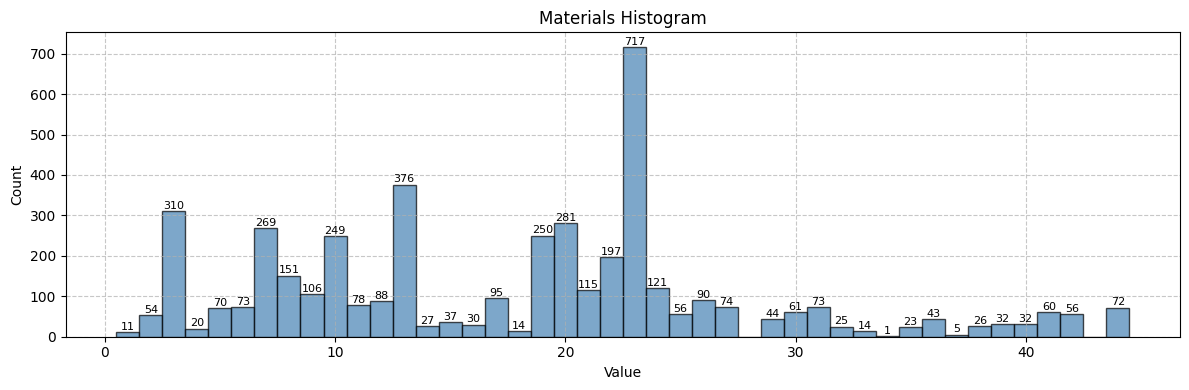

In [15]:
import time
start_time = time.time()
face_dist = explorer.create_distribution(key="part_label", bins=None, group="Labels")
print(f"Material distribution created in {(time.time() - start_time):.2f} seconds\n")
print_distribution_info(face_dist, title="Materials")

## Dataset Visualization with DatasetViewer

The **DatasetViewer** is a powerful visualization tool that bridges dataset queries and visual analysis. It enables you to quickly visualize query results in two ways:

1. **Image Grids**: Generate collages of PNG previews for rapid visual scanning
2. **Interactive 3D Views**: Open inline 3D viewers for detailed model inspection

In [16]:
# Import the DatasetViewer from the insights module
from hoops_ai.insights import DatasetViewer

# Create a DatasetViewer using the convenience method from_explorer
# This method queries the explorer and builds the file ID to visualization path mappings
dataset_viewer = DatasetViewer.from_explorer(explorer)

2026-01-25 17:25:08 | INFO | hoops_ai.insights.dataset_viewer | Initialized process pool with 4 workers
2026-01-25 17:25:08 | INFO | hoops_ai.insights.dataset_viewer | DatasetViewer initialized with reference directory: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training_b2
2026-01-25 17:25:08 | INFO | hoops_ai.insights.dataset_viewer | Built file mapping for 4521 files


In [17]:
start_time = time.time()

# condition
material_is_frequent = lambda ds: ds['part_label'] == 23

filelist = explorer.get_file_list(group="Labels", where=material_is_frequent)
print(f"Filtering completed in {(time.time() - start_time):.2f} seconds")
print(len(filelist))

Filtering completed in 0.23 seconds
716


### Example 1: Visualize Query Results as Image Grid

Now let's use the query results we obtained earlier and visualize them as a grid of images. This is perfect for quickly scanning through many files to understand patterns or identify specific cases.

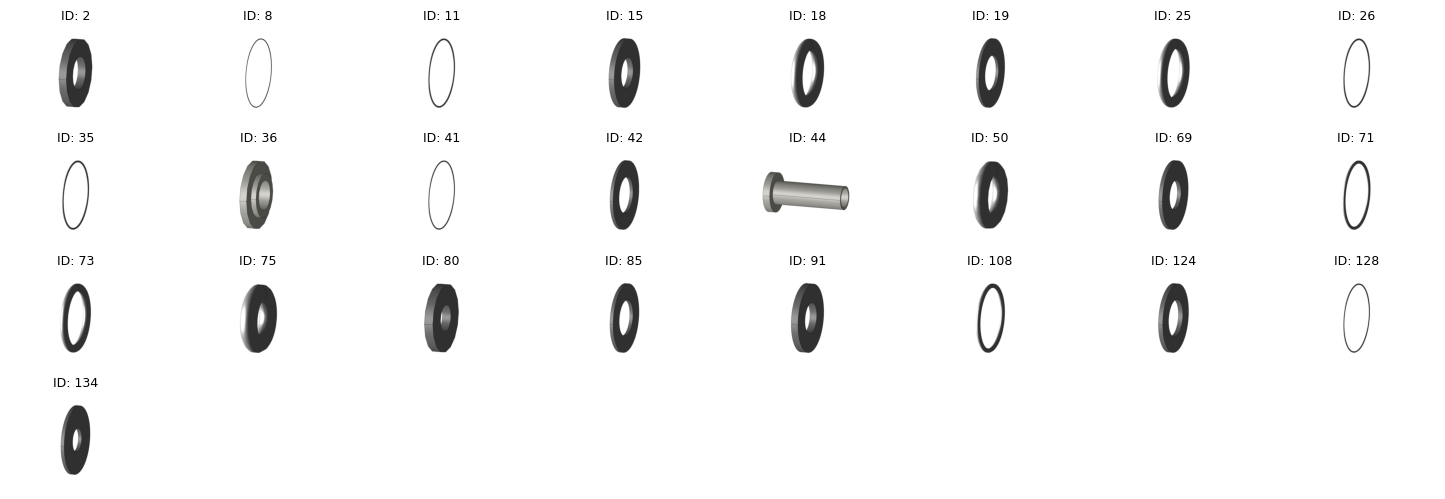

In [18]:
# Visualize the filtered files as a 5x5 grid with file IDs as labels
fig = dataset_viewer.show_preview_as_image(
    filelist, 
    k=25,                      # Show up to 25 files
    grid_cols=8,               # 5 columns
    label_format='id',         # Show file IDs as labels
    figsize=(15, 5)           # Larger figure size
)

plt.show()

# Machine Learning Training

In [19]:
# Load and split dataset for machine learning
from hoops_ai.dataset import DatasetLoader

flow_path = pathlib.Path(flow_file)
loader = DatasetLoader(
    merged_store_path=str(flow_path.parent / f"{flow_path.stem}.dataset"),  
    parquet_file_path=str(flow_path.parent / f"{flow_path.stem}.infoset")
)

# Split dataset by machining category with explicit group parameter
train_size, val_size, test_size = loader.split(
    key="part_label",
    group="Labels",  # Explicitly specify the group for clarity
    train=0.6, 
    validation=0.2, 
    test=0.2, 
    random_state=42
)

print(f"Dataset split: Train={train_size}, Validation={val_size}, Test={test_size}")

# Access training dataset
train_dataset = loader.get_dataset("train")
print(f"Training dataset ready with {len(train_dataset)} samples")

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:57019' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/4528 [00:00<?, ?it/s]


DATASET STRUCTURE OVERVIEW

Group: Labels
------------------------------
  file_id_code_Labels: (4533,) (int64)
  part_label: (4533,) (float64)

Group: edges
------------------------------
  edge_convexities: (314766,) (int32)
  edge_dihedral_angles: (314766,) (float32)
  edge_indices: (314766,) (int32)
  edge_lengths: (314766,) (float32)
  edge_types: (314766,) (int32)
  edge_u_grids: (314766, 10, 6) (float32)
  file_id_code_edges: (314766,) (int64)

Group: face_mesh
------------------------------
  face_mesh_adj: (122099, 10000) (float32)
  file_id_code_face_mesh: (122099,) (int64)

Group: faces
------------------------------
  face_areas: (122099,) (float32)
  face_discretization: (122099, 100, 7) (float32)
  face_indices: (122099,) (int32)
  face_loops: (122099,) (int32)
  face_types: (122099,) (int32)
  file_id_code_faces: (122099,) (int64)

Group: graph
------------------------------
  edges_destination: (314766,) (int32)
  edges_source: (314766,) (int32)
  file_id_code_graph: (

In [20]:
from hoops_ai.ml.EXPERIMENTAL import FlowTrainer


flow_root_dir = nb_dir.joinpath("out","flows","ETL_Fabwave_training")

In [21]:
flow_trainer = FlowTrainer(

    flowmodel       = my_workflow_for_fabewave,
    datasetLoader   = loader,
    experiment_name = "HOOPS_AI_train",
    result_dir      = flow_root_dir,
    accelerator     = 'cpu',
    devices         = 1,
    max_epochs      = 30,
    batch_size      = 64
    )

GRAPH CLASSIFICATION - HOOPS GAT - MODEL


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
trained_model_path = flow_trainer.train()
print(f"Training finished. Model checkpoint saved in {trained_model_path}")


-----------------------------------------------------------------------------------
GRAPH CLASSIFICATION - HOOPS GAT - MODEL - TRAINING STEP
-----------------------------------------------------------------------------------
Training batch size               : 64
Adjusted learning rate (for batch): 0.002

Train set contains                : 2714 samples (60.04%)
Validation set contains           : 903 samples (19.98%)
Test set contains                 : 903 samples (19.98%)
Total samples                     : 4520
Max Epoch                         : 30

The trained model: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training\ml_output\HOOPS_AI_train\0125\172522\best.ckpt

To monitor the logs, run:
tensorboard --logdir results/HOOPS_AI_train/0125/172522
-----------------------------------------------------------------------------------
        


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\LuisSalazar\miniconda3\envs\hoops_ai_cpu_dev\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Training finished. Model checkpoint saved in C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training\ml_output\HOOPS_AI_train\0125\172522\best.ckpt


In [23]:
## Testing phase
flow_trainer.test(trained_model_path)
print(f"Testing finished")


-----------------------------------------------------------------------------------
GRAPH CLASSIFICATION - HOOPS GAT - MODEL - TESTING STEP
-----------------------------------------------------------------------------------

The trained model: C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training\ml_output\HOOPS_AI_train\0125\172522\best.ckpt

Test set contains 903 training samples
-----------------------------------------------------------------------------------
        


Restoring states from the checkpoint path at C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training\ml_output\HOOPS_AI_train\0125\172522\best.ckpt
Loaded model weights from checkpoint at C:\Users\LuisSalazar\MAIN\repos\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training\ml_output\HOOPS_AI_train\0125\172522\best.ckpt


Testing: 0it [00:00, ?it/s]

Number of classes: 45


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            IoU            │    0.9856979498488931     │
│     overall_accuracy      │    0.9966517686843872     │
│    per_class_accuracy     │     0.990476131439209     │
│         test_acc          │    0.9966517686843872     │
│         test_loss         │   0.019277429208159447    │
└───────────────────────────┴───────────────────────────┘

Testing finished


In [24]:
explorer = DatasetExplorer(flow_output_file=str(flow_file))
explorer.print_table_of_contents()

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:62492' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/4528 [00:00<?, ?it/s]

[DatasetExplorer] All resources closed.

--- Dataset Table of Contents ---

LABELS_GROUP:
  FILE_ID_CODE_LABELS_DATA: Shape: (4533,), Dims: ('Labels_part_label_dim_0',), Size: 4533
  PART_LABEL_DATA: Shape: (4533,), Dims: ('Labels_part_label_dim_0',), Size: 4533

EDGES_GROUP:
  EDGE_CONVEXITIES_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766
  EDGE_DIHEDRAL_ANGLES_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766
  EDGE_INDICES_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766
  EDGE_LENGTHS_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766
  EDGE_TYPES_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766
  EDGE_U_GRIDS_DATA: Shape: (314766, 10, 6), Dims: ('edge', 'dim_x', 'component'), Size: 18885960
  FILE_ID_CODE_EDGES_DATA: Shape: (314766,), Dims: ('edge',), Size: 314766

FACE_MESH_GROUP:
  FACE_MESH_ADJ_DATA: Shape: (122099, 10000), Dims: ('face', 'component'), Size: 1220990000
  FILE_ID_CODE_FACE_MESH_DATA: Shape: (122099,), Dims: ('face',), Size: 122099

FACES

In [25]:
test_dataset = loader.get_dataset("test")
file_list = test_dataset.indices[:50]
print(file_list)

[  1   3   4   5   9  11  16  25  38  58  62  63  99 104 107 108 112 114
 118 121 129 130 133 147 155 158 162 165 169 173 176 194 202 204 206 207
 210 216 217 219 223 226 232 234 235 248 264 265 276 277]


In [ ]:
# Visualize the filtered files as a 5x5 grid with file IDs as labels
fig = dataset_viewer.show_preview_as_image(
    file_list, 
    k=len(file_list),                      # Show up to 25 files
    grid_cols=8,               # 5 columns
    figsize=(50, 15)           # Larger figure size
)

plt.show()